### Image Captioning 
###### Dataset used Flickr 8k
## Neural Network used CNN(InceptionV3) and LSTM

Importing all necessary Libraries
PIL is the Python Imaging Library 
The Image module provides a class with the same name which is used to represent a PIL image.
The module also provides a number of factory functions, including functions to load images from files, and
to create new images.
GLOB -The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix
shell, although results are returned in arbitrary order
Pickle -The pickle module implements binary protocols for serializing and de-serializing a Python object structure. “Pickling”
is the process whereby a Python object hierarchy is converted into a byte stream, and “unpickling” is the inverse operation,
whereby a byte stream (from a binary file or bytes-like object) is converted back into an object hierarchy

In [2]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


Loading all the docs in files

In [3]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "Flickr8k_text\Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
# print(doc[:300])

putting all the descriptions of each image in dictionary

In [4]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


We will clean the text in the following ways in order to reduce the size of the vocabulary of words we will need to work with:

*Convert all words to lowercase.
*Remove all punctuation.
*Remove all words that are one character or less in length (e.g. ‘a’).
*Remove all words with numbers in them.

In [5]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

converting the tokenized description into dictionary so that there are no duplicate words hence forming a vocabulary with no 
duplicate words

In [6]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [7]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

Loadind the names of all Training datasets from trainImages.txt

In [8]:
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [9]:
# Below path contains all the images
images = 'Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [9]:
len(images)

18

Now seperating all the train images names and listing them

In [10]:
# Below file conatains the names of images to be used in train data
train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images
print(len(train_img))

6000


In [11]:
train_img[1]

'Flicker8k_Dataset\\1001773457_577c3a7d70.jpg'

Similarly seperating Test Images

In [11]:
# Below file conatains the names of images to be used in test data
test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

We will clean the text in the following ways in order to reduce the size of the vocabulary of words we will need to work with:

**Convert all words to lowercase.
**Remove all punctuation.
**Remove all words that are one character or less in length (e.g. ‘a’).
**Remove all words with numbers in them.

In [12]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


converting  all images into 299x299 since  its the input to Inceptionv3
and converting images into numpy array of 3-d

In [13]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

Downloads the Weight of InceptionV3 which was trained for Imagenet dataset

In [14]:
model = InceptionV3(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
96116736/96112376 [==============================] - 91s 1us/step


### Since this is not classification problem we remove the last two layers (output softmax layer)

In [15]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [16]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [17]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 329.8057677745819


In [19]:
# Save the bottleneck train features to disk
import pickle
with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

Repeating same process for test images encoding them and calculating time taken for encoding

In [20]:
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 50.24073076248169


Storing Encoded test in encoded_test_images.pkl file for future use

In [21]:
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

Just Checking the number of Train Images

In [22]:
train_features = load(open("encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [23]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
# len(all_train_captions)

Removing words that occur less

In [24]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


 encode each word into a fixed sized vector
 “wordtoix” (pronounced — word to index) and “ixtoword” (pronounced — index to word).

In [25]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [26]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

Here we Find the maximum llength of Descriptions since each Description are made of couple of lines we first get each line
using to_line() function and we calculate the length of 
each line and send the maximmum value of it using max_length function

In [27]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


## Data Generator
#### This Function takes descriptions, photos, wordtoix, max_length, number of photos per batch and does the progressive loading of image the progressive loading of images so that we can load training data as required. Here, first we loop over all images get their features encode them ......

In [28]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

###### Using Glove is Global Vectors for word representation i.e. words are represented by vectors of numerical values 

In [29]:
# Load Glove vectors
embeddings_index = {} # empty dictionary
f = open('glove.6B.200d.txt',encoding='utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [30]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [31]:
embedding_matrix.shape

(1652, 200)

# Making the model
### input1 takes input from inceptionv3 model which is of size (2048, ) 
### input1 goes to fe1 which randomly drops(regularization) 50% input neurons so that we can avoid overfitting 
### fe1 is connected to fe2 which outputs a vector of (,256)  with relu activation 
### then in Caption side we take input2 of (max_length,) vector where max_length is maximum length of our caption
### The Sequence Processor(s1) model expects input sequences with a pre-defined length (34 words) which are fed into an Embedding layer that uses a mask to ignore padded values. This is followed by an LSTM layer with 256 memory units.
###  both input1 and input2 finally produce 256 element vector and are merged in one by decoder1 and decoder2 adds dense model with relu activation 
### This is then fed to a Dense 256 neuron layer and then to a final output Dense layer that makes a softmax prediction over the entire output vocabulary for the next word in the sequence.

### In summary our model has to input layers and one outpot layer apart from InceptionV3

In [32]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [33]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [34]:
model.layers[2]

Notice that since we are using a pre-trained embedding layer, we need to freeze it (trainable = False), before training the model, so that it does not get updated during the backpropagation

In [35]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [36]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [37]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [38]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 135s 68ms/step - loss: 4.1145
Epoch 1/1
2000/2000 [==============================] - 134s 67ms/step - loss: 3.4160
Epoch 1/1
2000/2000 [==============================] - 133s 67ms/step - loss: 3.1979
Epoch 1/1
2000/2000 [==============================] - 135s 68ms/step - loss: 3.0688
Epoch 1/1
2000/2000 [==============================] - 135s 67ms/step - loss: 2.9734
Epoch 1/1
2000/2000 [==============================] - 135s 67ms/step - loss: 2.9009
Epoch 1/1
2000/2000 [==============================] - 134s 67ms/step - loss: 2.8456
Epoch 1/1
2000/2000 [==============================] - 135s 68ms/step - loss: 2.7983
Epoch 1/1
2000/2000 [==============================] - 135s 67ms/step - loss: 2.7585
Epoch 1/1
2000/2000 [==============================] - 135s 67ms/step - loss: 2.7234


In [39]:
# for i in range(epochs):
#     generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
#     model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#     model.save('model_' + str(i) + '.h5')

In [40]:
# model.optimizer.lr = 0.0001
# epochs = 10
# number_pics_per_bath = 6
# steps = len(train_descriptions)//number_pics_per_bath

In [41]:
# for i in range(epochs):
#     generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
#     model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#     #model.save('./model_weights/model_' + str(i) + '.h5')

In [42]:
model.save_weights('model_30.h5')

In [43]:
model.load_weights('model_30.h5')

In [44]:
images = 'Flicker8k_Dataset/'

In [45]:
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [46]:
def caption(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

1056338697_4f7d7ce270.jpg


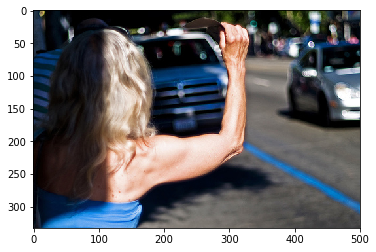

Caption: man in black shirt and jeans is sitting on bench
1287475186_2dee85f1a5.jpg


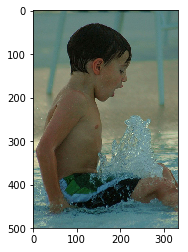

Caption: boy in swimming trunks swims in the water
1425069308_488e5fcf9d.jpg


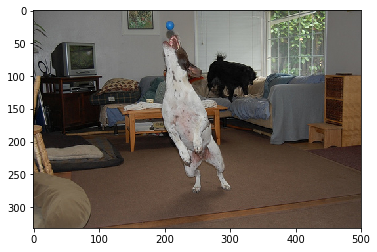

Caption: two dogs are playing on the floor
1659358141_0433c9bf99.jpg


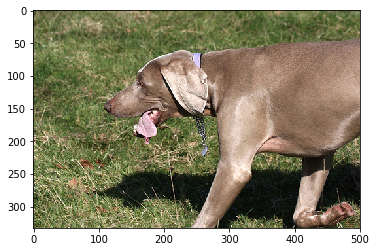

Caption: two dogs are wrestling in the grass
2021613437_d99731f986.jpg


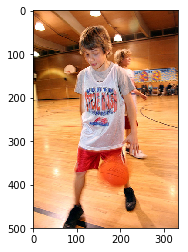

Caption: boy in red shirt is running through the street
2128119486_4407061c40.jpg


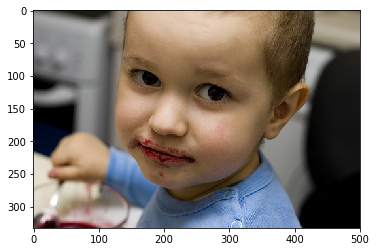

Caption: boy with his hair and his face
2216695423_1362cb25f3.jpg


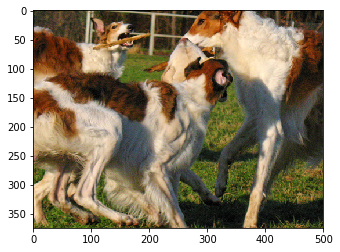

Caption: two dogs are playing tug of war
229862312_1a0ba19dab.jpg


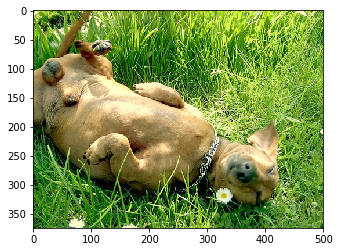

Caption: two dogs are playing tug of war
2393264648_a280744f97.jpg


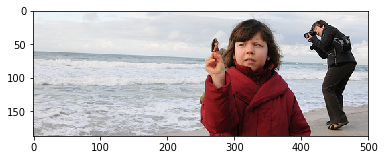

Caption: two people are sitting on the edge of the water
245252561_4f20f1c89e.jpg


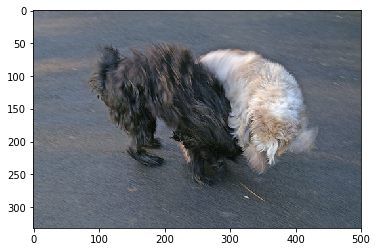

Caption: two dogs are playing tug of war
2501595799_6316001e89.jpg


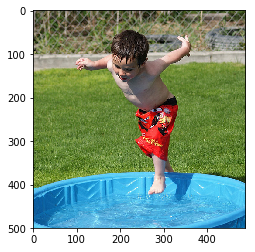

Caption: boy in red shirt is playing in water
2573625591_70291c894a.jpg


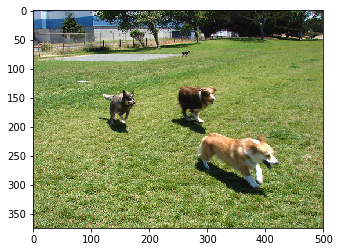

Caption: beagle is playing with ball
2641770481_c98465ff35.jpg


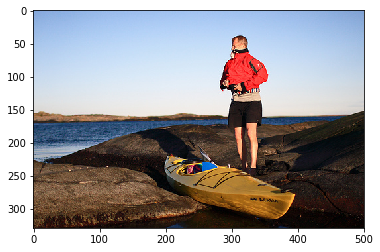

Caption: man is standing on the edge of dock looking at the ocean
270724499_107481c88f.jpg


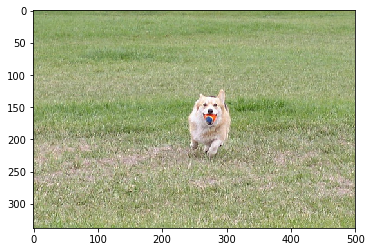

Caption: dog is running through the grass
280706862_14c30d734a.jpg


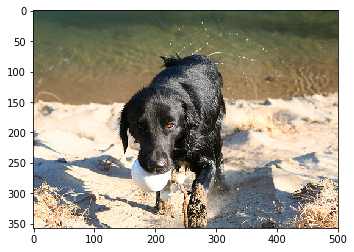

Caption: black dog is running through the water
2883099128_0b056eed9e.jpg


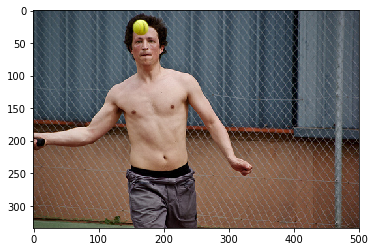

Caption: man in black shirt is walking along the beach
2928152792_b16c73434a.jpg


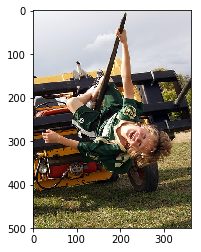

Caption: two boys are sitting on the top of the of green and yellow and red truck
2991994415_504d1c0a03.jpg


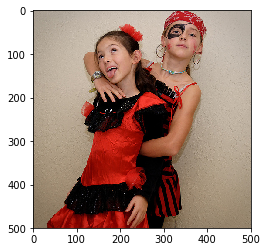

Caption: woman in black and white shirt is standing next to bus
3044746136_8b89da5f40.jpg


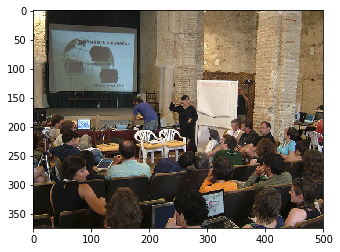

Caption: group of people are sitting around table
3100251515_c68027cc22.jpg


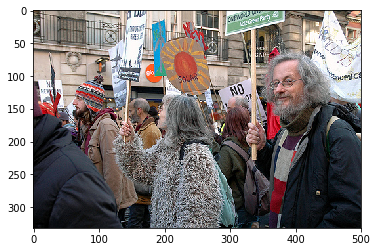

Caption: man in black shirt is standing in front of crowd
3149919755_f9272b10b3.jpg


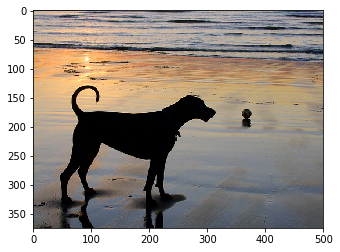

Caption: two dogs are playing in the water
3197917064_e679a44b8e.jpg


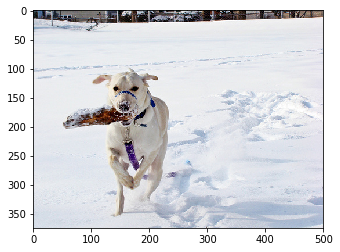

Caption: dog is running through the snow
3224227640_31865b3651.jpg


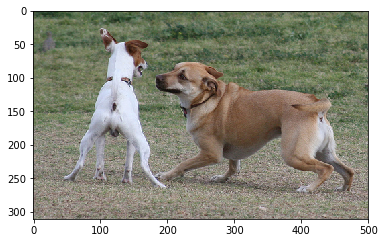

Caption: two dogs are playing tug of war
3259666643_ae49524c81.jpg


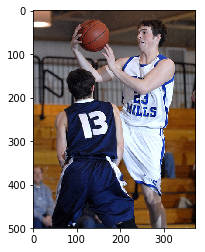

Caption: two men are playing basketball on the field
3323988406_e3c8fce690.jpg


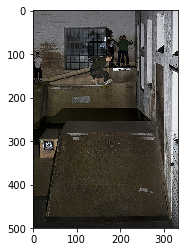

Caption: man is sitting on bench next to his luggage
3375070563_3c290a7991.jpg


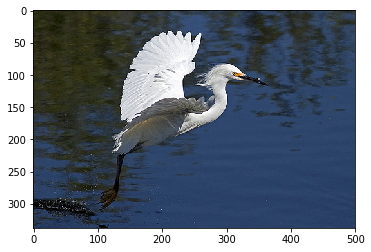

Caption: white crane flies over water
3429956016_3c7e3096c2.jpg


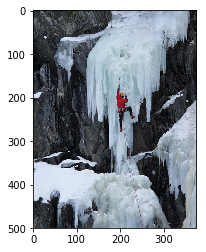

Caption: two people are sitting on top of mountain
3473264983_67917a931f.jpg


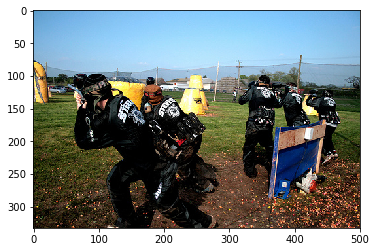

Caption: two men are riding horses on the street
3514179514_cbc3371b92.jpg


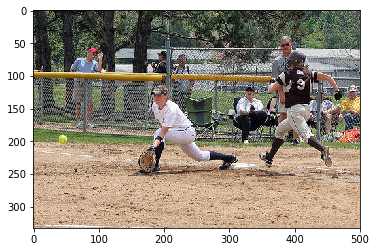

Caption: boy in red shirt and blue shirt is playing baseball
3562050678_4196a7fff3.jpg


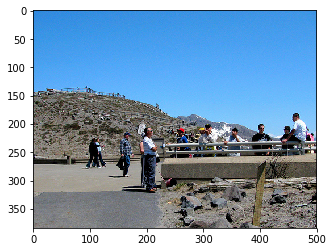

Caption: two people are sitting on the edge of cliff
3596131692_91b8a05606.jpg


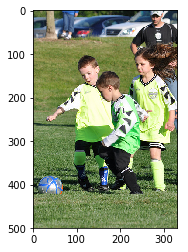

Caption: two boys play soccer on field
3655074079_7df3812bc5.jpg


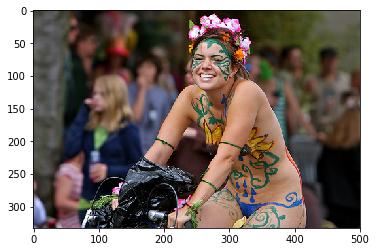

Caption: man in black and white outfit and leather costume is wearing helmet
3725202807_12fbfdd207.jpg


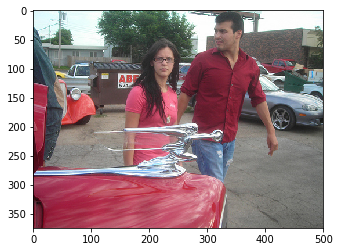

Caption: man in black shirt is sitting on bench
424779662_568f9606d0.jpg


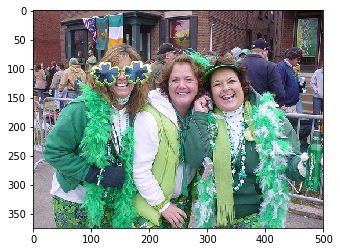

Caption: two women in dresses are standing next to each other
486712504_36be449055.jpg


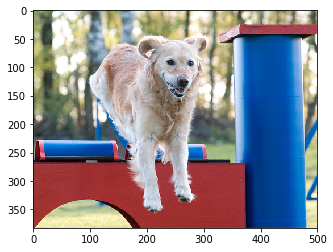

Caption: dog is running through the grass
53043785_c468d6f931.jpg


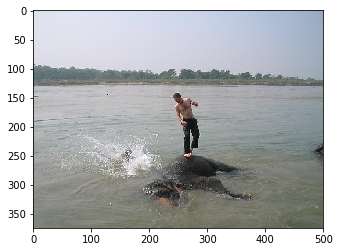

Caption: boy in red shirt is jumping into the water
732468337_a37075225e.jpg


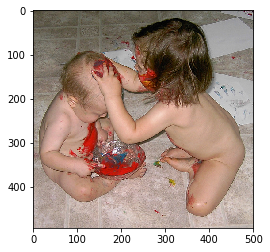

Caption: boy in red shirt is playing with water


In [47]:
for z in range(0,999,27):
    pic = list(encoding_test.keys())[z]
    print(pic)
    image = encoding_test[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print("Caption:",caption(image))

In [48]:
# extract features from each photo in the directory
def extract_features(filename):
    model = InceptionV3(weights='imagenet')
    model = Model(model.input, model.layers[-2].output)
    image = load_img(filename, target_size=(299, 299))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
	# reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the Inception model
    image = preprocess_input(image)
	# get features
    feature = model.predict(image, verbose=0)
    return feature

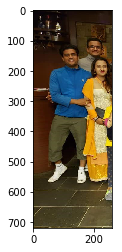

group of people are gathered around


In [49]:
pic = ('ABC.jpg')
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
x=plt.imread(pic)
plt.imshow(x)
plt.show()
encoded = extract_features(pic)
print(caption(encoded))

In [50]:
# def extract_features(filename):
#     abc = InceptionV3(weights='imagenet')
#     abc_new = Model(model.input, model.layers[-2].output)
#     image = load_img(filename, target_size=(299, 299))
# 	# convert the image pixels to a numpy array
#     image = img_to_array(image)
# 	# reshape data for the model
# #    image = np.expand_dims(image, axis=0)
#     image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# 	# prepare the image for the VGG model
#     image = preprocess_input(image)
# 	# get features
#     feature = abc_new.predict(image, verbose=0)
#     return feature

In [51]:
# from numpy import argmax
# from pickle import load
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import load_model
# from nltk.translate.bleu_score import corpus_bleu
# # evaluate the skill of the model
# def evaluate_model(model, descriptions, photos, tokenizer, max_length):
# 	actual, predicted = list(), list()
# 	# step over the whole set
# 	for key, desc_list in descriptions.items():
# 		# generate description
# 		yhat = generate_desc(model, tokenizer, photos[key], max_length)
# 		# store actual and predicted
# 		references = [d.split() for d in desc_list]
# 		actual.append(references)
# 		predicted.append(yhat.split())
# 	# calculate BLEU score
# 	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
# 	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
# 	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
# 	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
# # load the model
# filename = 'model_9.h5'
# model = load_model(filename)
# # evaluate model
# evaluate_model(model, test_descriptions, test_features, description, max_length)